# XXZ Spin chain with many-body localization transition 

As a second example of a spin model, we choose the XXZ model below. In contrast the the transverse Ising model where we have looked at a quantum phase transition in the spin order, here we will investigate the many-body localization transition as a function of disoder. Models with MBL transitions have become increasing attractive with recent experimental developements. Cold atom systems, trapped ions, superconducting qubits and new quantum engineered materials all offer ways to actually realize MBL phases. 

The model

$$ H = \frac{J_{\perp}}{2} \sum_{i=0}^{N-1} \left( \sigma_i^x \sigma_{i+1}^x + \sigma_i^y \sigma_{i+1}^y \right) + \sum_{i=0}^{N-1} \left(\frac{J_{\parallel}}{2} \sigma_i^z \sigma_{i+1}^z + h^z_i \sigma_i^z \right) $$

There are three energy scales in the problem, but due to computational constraints, we need to fix some. We choose to fix the couplings $J_1$ and $J_2$. In this case the critical disorder strength is known to be around $g_c \approx 3.5$.

The local fields $h^z_i$ are set to a random number on the interval $[W,W]$ 

The operators are understood to be the $N$-fold product of the spin space

$$ \sigma_i = \mathbf{1} \otimes ... \otimes \sigma \otimes \mathbf{1} ... \otimes \mathbf{1} $$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import seed, uniform
from qutip import *
import sys
import os

### Define the functions to construct the energy operator

In [2]:
def transverse(N, site):
    op = []
    
    for i in range(N):
        op.append(qeye(2))
        
    op[site] = sigmax()
    
    return tensor(op)

def longitudinal(N, site):
    op = []
    
    for i in range(N):
        op.append(qeye(2))
        
    op[site] = sigmaz()
    
    return tensor(op)

def surface(N, site):
    op = []
    
    for i in range(N):
        op.append(qeye(2))
        
    op[site] = sigmay()
    
    return tensor(op)

def perp_coupling(N, site):
    if (site == N-1):
        return transverse(N,site) * transverse(N, 0) + surface(N,site) * surface(N,0) 
    else:
        return transverse(N,site) * transverse(N, site+1) + surface(N,site) * surface(N, site+1)
    
def para_coupling(N, site):
    if (site == N-1):
        return longitudinal(N,site) * longitudinal(N, 0)
    else:
        return longitudinal(N,site) * longitudinal(N, site+1)

def H(N, W, Jpara, Jperp):
    term1 = perp_coupling(N, 0) 
    term2 = para_coupling(N, 0)
    term3 = uniform(-W, W) * longitudinal(N, 0)
       
    for site in range(1, N):
        term1 += perp_coupling(N,site)
        term2 += para_coupling(N,site)
        term3 += uniform(-W/2, W/2) * longitudinal(N,site)
    
    return (Jperp/N) * term1 + (Jpara/N) * term2 + term3

In [3]:
#plt.spy(H(6,1,1,1).full())
#plt.show()

In [4]:
def mag(N):
    tmp = longitudinal(N, 0)
    for site in range(1, N):
        tmp += longitudinal(N,site)
    return 0.5 * tmp

## Now define functions returning the parts of the dataset to be written to file

In [5]:
def disorder_coupling_meshgrid(W_min, W_max, W_instances, W_realizations, Jpara_min, Jpara_max, nJpara):
    
    mat = np.zeros((W_instances*nJpara, 2), np.float64)
    
    if W_instances%W_realizations != 0:
        print("INCREASE INSTANCES OR DECREASE DISORDER REALIZATIONS")
        raise KeyboardInterrupt

    Ws = np.linspace(W_min, W_max, W_instances/W_realizations)
    Js = np.linspace(Jpara_min, Jpara_max, nJpara)

    c = 0
    for W in Ws:
        for realization in range(W_realizations):
            for J in Js:
                mat[c, :] = W,J
                c += 1
            
    np.random.shuffle(mat)
    return mat

In [6]:
def groundstate_wavefunction_from_qutip(qutip_groundstate_object):
    return qutip_groundstate_object[1].full().real.flatten()

def groundstate_eigenenergy_from_qutip(qutip_groundstate_object):
    return qutip_groundstate_object[0].real

def values_array_from_qutip_hamiltonian(qutip_hamiltonian):
    tmp = qutip_hamiltonian.full().real
    dim = qutip_hamiltonian.shape[0]
    iu1 = np.triu_indices(dim)
    return tmp[iu1][np.nonzero(tmp[iu1])]
    
def locations_array_from_qutip_hamiltonian(qutip_hamiltonian):
    tmp = qutip_hamiltonian.full().real
    dim = qutip_hamiltonian.shape[0]
    iu1 = np.triu_indices(dim)
    return np.nonzero(tmp[iu1])[0]

def flattened_hams_gsvecs_and_enes_on_meshgrid(N, J, meshgrid):
    instances = np.size(meshgrid,0)
    dim = 2**N
    nnz = len(values_array_from_qutip_hamiltonian(H(N, 0.5, 1, 1)))
    
    vecs = np.empty((instances, dim), np.float64)
    enes = np.empty((instances, 1), np.float64)
    matval = np.empty((instances, nnz), np.float64)
    matloc = np.empty((instances, nnz), np.int32)
    
    for i in range(instances):  
        ham = H(N, meshgrid[i,0], meshgrid[i,1], J)
        gs = ham.groundstate()
        vecs[i,:] = groundstate_wavefunction_from_qutip(gs)
        enes[i,:] = groundstate_eigenenergy_from_qutip(gs)
        matval[i,:] = values_array_from_qutip_hamiltonian(ham)
        matloc[i,:] = locations_array_from_qutip_hamiltonian(ham)
        
    return matval.flatten(),matloc.flatten(),vecs.flatten(),enes.flatten()

def write_data(N, J, meshgrid, dir_prefix):
    instances = np.size(meshgrid,0)
    dim = 2**N
    nnz = len(values_array_from_qutip_hamiltonian(H(N, 0.5, 1, 1)))
    
    header = np.array([instances, nnz, dim], np.int32)
    fields = meshgrid[:,0].flatten()
    
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)
    
    header_path = f"{dir_prefix}header.bin"
    fields_path = f"{dir_prefix}fields.bin"
    matval_path = f"{dir_prefix}matval.bin"
    matloc_path = f"{dir_prefix}matloc.bin"
    wavefx_path = f"{dir_prefix}wavefx.bin"
    energy_path = f"{dir_prefix}energy.bin"

    matval,matloc,wavefx,energy = flattened_hams_gsvecs_and_enes_on_meshgrid(N, J, meshgrid)
    
    with open(header_path, 'wb') as file:
        header.tofile(file)
    
    with open(fields_path, 'wb') as file:
        fields.tofile(file)

    with open(matval_path, 'wb') as file:
        matval.tofile(file)
    
    with open(matloc_path, 'wb') as file:
        matloc.tofile(file)
        
    with open(wavefx_path, 'wb') as file:
        wavefx.tofile(file)
        
    with open(energy_path, 'wb') as file:
        energy.tofile(file)
        
def get_dataset(dir_prefix):
    with open(dir_prefix + "header.bin", 'rb') as file:
        header = np.fromfile(file, dtype=np.int32)
    
    with open(dir_prefix + "matloc.bin", 'rb') as file:
        matloc = np.fromfile(file, dtype=np.int32)
    
    with open(dir_prefix + "matval.bin", 'rb') as file:
        matval = np.fromfile(file, dtype=np.float64)
    
    with open(dir_prefix + "wavefx.bin", 'rb') as file:
        wavefx = np.fromfile(file, dtype=np.float64)
        
    with open(dir_prefix + "energy.bin", 'rb') as file:
        energy = np.fromfile(file, dtype=np.float64)
        
    with open(dir_prefix + "fields.bin", 'rb') as file:
        fields = np.fromfile(file, dtype=np.float64)
        
    return header,fields,matloc,matval,wavefx,energy

def reconstructed_hamiltonian(instance, header, matval, matloc):
    nnz = header[1]
    dim = header[2]
    ham = np.zeros((dim,dim))
    uta = np.zeros(int(dim*(dim+1)/2))
    lb = instance*nnz
    
    for i in range(nnz):
        uta[matloc[i + lb]] = matval[i + lb]

    k = 0
    for i in range(dim):
        for j in range(i,dim):
            ham[i,j] = uta[k]
            ham[j,i] = uta[k]
            k += 1
        
    return ham

In [17]:
root = "/home/csingh5/Documents/Guided-Machine-Learning/code/chris/data/input/"
header,fields,matloc,matval,wavefx,energy = get_dataset(root + "Ising/10-qubits/40k-instances/dual-phase/training/")

In [15]:
energy.max()

-1.0100248757727754

In [16]:
energy.min()

-2.1273632550773818

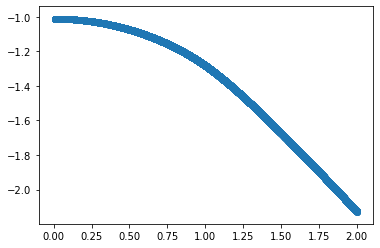

In [19]:
plt.scatter(fields, energy)
plt.show()

In [6]:
root = "/home/csingh5/Documents/Guided-Machine-Learning/code/chris/data/input/XXZ/"

#print("got: ", sys.argv[1], " qubits")
qubits = [sys.argv[1]]
dsizes = [int(sys.argv[2])]
sampts = ["single-phase/", "dual-phase/"]
splits = ["training/", "validation/", "testing/"]

Jperp = 1
W_realizations = 1000
W_min = 0.01
Jpara_min = 1; Jpara_max = 1; nJpara = 1;
    
for qubit in qubits:
    for dsize in dsizes:
        for sampt in sampts:
            for split in splits:
                dir_prefix = root + str(qubit) + "-qubits/" + str(dsize) + "k-instances/" + sampt + split
                
                # figure out max disorder strength
                if sampt == "dual-phase/" or split == "testing/":
                    W_max = 5
                else:
                    W_max = 2.5
                
                # figure out number of instances 
                if split == "training/":
                    W_instances = dsize * 700
                elif split == "validation/":
                    W_instances = dsize * 200
                else:
                    W_instances = dsize * 100
                    
                grid = disorder_coupling_meshgrid(W_min, W_max, W_instances, W_realizations, Jpara_min, Jpara_max, nJpara)
                write_data(int(qubit), Jperp, grid, dir_prefix)
                print("finished:", dir_prefix, W_instances)

finished: /home/csingh5/Documents/Guided-Machine-Learning/code/chris/data/input/XXZ/-f-qubits/40k-instances/single-phase/training/ 28000
finished: /home/csingh5/Documents/Guided-Machine-Learning/code/chris/data/input/XXZ/-f-qubits/40k-instances/single-phase/validation/ 8000
finished: /home/csingh5/Documents/Guided-Machine-Learning/code/chris/data/input/XXZ/-f-qubits/40k-instances/single-phase/testing/ 4000
finished: /home/csingh5/Documents/Guided-Machine-Learning/code/chris/data/input/XXZ/-f-qubits/40k-instances/dual-phase/training/ 28000
finished: /home/csingh5/Documents/Guided-Machine-Learning/code/chris/data/input/XXZ/-f-qubits/40k-instances/dual-phase/validation/ 8000
finished: /home/csingh5/Documents/Guided-Machine-Learning/code/chris/data/input/XXZ/-f-qubits/40k-instances/dual-phase/testing/ 4000
finished: /home/csingh5/Documents/Guided-Machine-Learning/code/chris/data/input/XXZ/-f-qubits/60k-instances/single-phase/training/ 42000
finished: /home/csingh5/Documents/Guided-Machine-

In [7]:
def T(potential_row_index, dim):
    i = potential_row_index
    return (i+1) * dim - int((i*i + i + 2)/2)

def spmv(header, matloc, matval, vector):
    dim = header[2]
    nnz = header[1]
    resultant = np.zeros(len(vector))
    previous_valid_row_index = 0

    for i in range(nnz):
        for potential_row_index in range(previous_valid_row_index, dim):
            if matloc[i] <= T(potential_row_index, dim):
                actual_row_index = potential_row_index
                previous_valid_row_index = potential_row_index
                actual_col_index = matloc[i] - (T(actual_row_index - 1, dim) + 1) + actual_row_index

                resultant[actual_row_index] += matval[i] * vector[actual_col_index]
                if (actual_row_index != actual_col_index):
                    resultant[actual_col_index] += matval[i] * vector[actual_row_index]
                break;
                
    return resultant